In [2]:
import deepchem as dc

import pandas as pd
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import ast
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

from sklearn.preprocessing import LabelEncoder

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('../../data/BST.csv',encoding = 'gb2312')

In [3]:
data

,Name,SMILES,Flavor type,Data resource,Label
0,Conessine hydrobromide,Br.Br.CC1C2CCC3C4CC=C5CC(N(C)C)CCC5(C)C4CCC32CN1C,Bitter,"BitterSweet, PlantMolecularTasteDB, BitterDB, ...",[1]
1,Arecoline hydrobromide,Br.COC(=O)C1=CCCN(C)C1,Bitter,"BitterSweet, BitterDB, ChemTasteDB",[1]
2,Avocadyne,C#CCCCCCCCCCCCC(O)CC(O)CO,Bitter,"PlantMolecularTasteDB, BitterDB, ChemTasteDB",[1]
3,"1-Acetoxy-2,4-dihydroxyheptadeca-16-yne",C#CCCCCCCCCCCCC(O)CC(O)COC(C)=O,Bitter,"BitterDB, ChemTasteDB",[1]
4,Hydrogen cyanide,C#N,Bitter,"BitterSweet, BitterDB, ChemTasteDB",[1]
...,...,...,...,...,...
13021,CNP0005404,O=C1N(CC2=NC=CC=C2)CC3N1CCN(CC=4C=CC=CC4)C3,Tasteless,Coconut,[3]
13022,CNP0005405,O=C1N(CC=2C=NC=CC2)CC3N1CCN(C3)C4CCOCC4,Tasteless,Coconut,[3]
13023,CNP0005406,O=C1N(C=2C=CC=CC2)CC3N1CCN(C3)C4CCN(C(=O)C)CC4,Tasteless,Coconut,[3]
13024,CNP0005407,O=C1N(C=2C=CC=CC2)CC3N1CCN(CC4=NC=CC=C4)C3,Tasteless,Coconut,[3]


# 特征提取

In [4]:
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(data['SMILES'])
#dataset = dc.data.NumpyDataset(features,data['Label'])

In [5]:
features.shape

(13026, 209)

In [6]:
nan_columns = np.isnan(features).any(axis=0)
deleted_columns = np.where(nan_columns)[0]
features_without_nan = features[:, ~nan_columns]

In [7]:
print("删除的列索引：", deleted_columns)

删除的列索引： [10 11 12 13 17 18 19 20 21 22 23 24]


In [8]:
features_without_nan.shape

(13026, 197)

In [9]:
from sklearn.feature_selection import VarianceThreshold

# 初始化VarianceThreshold对象
vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

# 进行特征选择
X_new = vt.fit_transform(features_without_nan)
dataset = dc.data.NumpyDataset(X_new,data['Label'])

In [10]:
X_new.shape

(13026, 157)

## 数据划分

In [11]:
splitter = dc.splits.RandomSplitter()#ScaffoldSplitter()
train_dataset,test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=300)

# Multi-label

In [12]:
train_dataset_y = [ast.literal_eval(label) for label in train_dataset.y]
test_dataset_y  = [ast.literal_eval(label) for label in test_dataset.y]
train_new_y = MultiLabelBinarizer().fit_transform(train_dataset_y)
test_new_y = MultiLabelBinarizer().fit_transform(test_dataset_y)

# Data distribution ratio

In [13]:
def row_counter(my_array):
    list_of_tups = [tuple(ele) for ele in my_array]
    return Counter(list_of_tups)

In [14]:
print('train_dataset:',row_counter(train_new_y))
train_counter = row_counter(train_new_y)
print('Bitter : Sweet : Tasteless = ',train_counter[(1, 0, 0)]/10420,':',train_counter[(0, 1, 0)]/10420,':',train_counter[(0, 0, 1)]/10420)
print('test_dataset:',row_counter(test_new_y))
test_counter = row_counter(test_new_y)
print('Bitter : Sweet : Tasteless = ',test_counter[(1, 0, 0)]/2606,':',test_counter[(0, 1, 0)]/2606,':',test_counter[(0, 0, 1)]/2606)

train_dataset: Counter({(0, 1, 0): 4900, (0, 0, 1): 3987, (1, 0, 0): 1533})
Bitter : Sweet : Tasteless =  0.14712092130518234 : 0.47024952015355087 : 0.3826295585412668
test_dataset: Counter({(0, 1, 0): 1199, (0, 0, 1): 994, (1, 0, 0): 413})
Bitter : Sweet : Tasteless =  0.15848042977743668 : 0.4600920951650038 : 0.3814274750575595


# GridSearchCV

In [15]:
scoring = {
     'F1_score': make_scorer(f1_score,average ='macro'),
     'Accuracy': make_scorer(accuracy_score),
     'Recall': make_scorer(recall_score,average = 'macro'),
     'Precision':make_scorer(precision_score,average = 'macro'),
}


param_grid = {
    'estimator__n_estimators': [220,240,260,280,300,320,340],
    'estimator__max_depth': [40,50,60,70,80],
}

In [16]:
classifier = RandomForestClassifier(random_state=42)
ovr = OneVsRestClassifier(classifier)

gs = GridSearchCV(
                    ovr,
                    param_grid,
                    scoring = scoring,
                    cv = KFold(n_splits=5, shuffle=True, random_state=300),
                    n_jobs = 25,
                    refit = 'F1_score',
                    return_train_score = True)

gs_fit = gs.fit(train_dataset.X,train_new_y)

In [17]:
val_F1 = gs.best_score_
val_ACC = gs.cv_results_['mean_test_Accuracy'][gs.best_index_]
val_Recall = gs.cv_results_['mean_test_Recall'][gs.best_index_]
val_Precision = gs.cv_results_['mean_test_Precision'][gs.best_index_]

In [18]:
print('Best parameters: ', gs.best_params_)
print('Best score (F1): ', val_F1)
print('Accuracy:',val_ACC)
print('Recall:',val_Recall)
print('Precision:',val_Precision)

Best parameters:  {'estimator__max_depth': 50, 'estimator__n_estimators': 320}
Best score (F1):  0.8453650051671622
Accuracy: 0.8443378119001919
Recall: 0.8001221139647677
Precision: 0.901729469286277


In [19]:
model_multi = gs_fit.best_estimator_
model_multi

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=50,
                                                     n_estimators=320,
                                                     random_state=42))

# Evaluate model

In [20]:
y_test_pred = model_multi.predict(test_dataset.X)
y_test_pred

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [21]:
# 将真实标签和预测标签转换为整数形式
y_true = np.argmax(test_new_y, axis=1)
y_pred = np.argmax(y_test_pred, axis=1)

In [22]:
# 将标签转换为整数形式
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y_true)
y_pred = label_encoder.transform(y_pred)

In [23]:
cm = confusion_matrix(y_true, y_pred)

In [24]:
cm

array([[ 341,   20,   52],
       [  53, 1112,   34],
       [ 127,   62,  805]], dtype=int64)

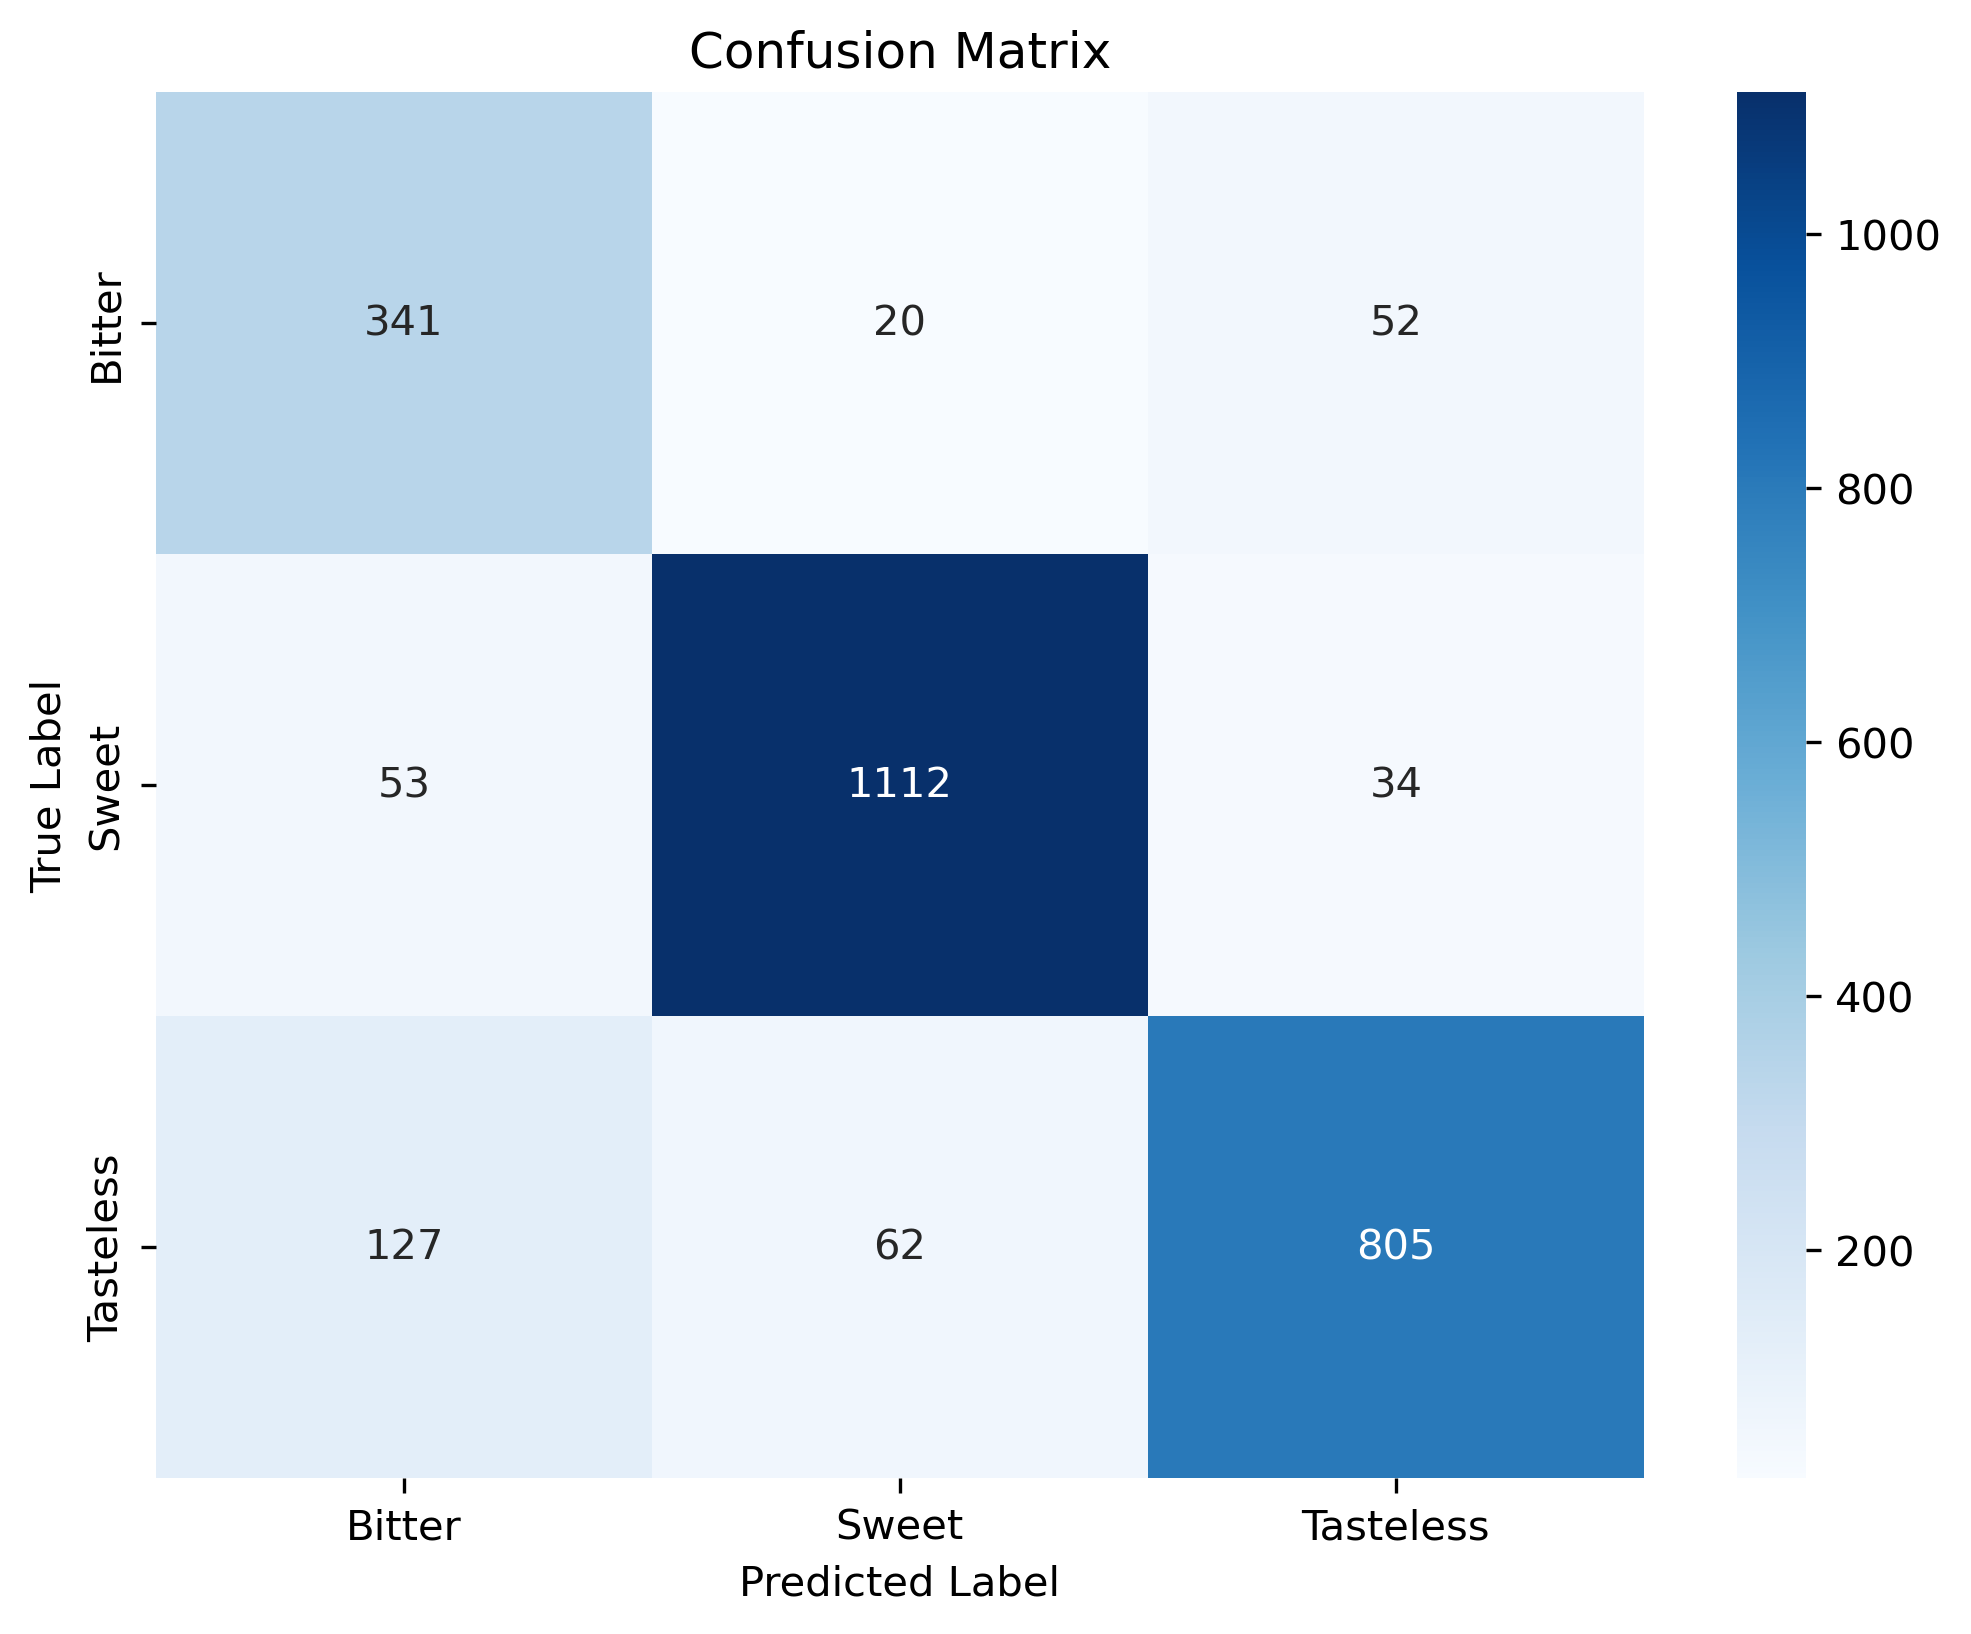

In [25]:
class_names = label_encoder.classes_  # 类别名称

# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 标准化混淆矩阵
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
test_F1 = f1_score(test_new_y, y_test_pred,average ='macro')
test_ACC = accuracy_score(test_new_y, y_test_pred)
test_Recall = recall_score(test_new_y,y_test_pred,average = 'macro')
test_Precision = precision_score(test_new_y, y_test_pred,average = 'macro')

In [27]:
rf_performance_dataset = {
    'F1_score':[val_F1,test_F1],
    'ACC':[val_ACC,test_ACC],
    'Recall':[val_Recall,test_Recall],
    'Precision':[val_Precision,test_Precision],
}

In [28]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,F1_score,ACC,Recall,Precision
val,0.845365,0.844338,0.800122,0.901729
test,0.841777,0.839217,0.801472,0.890531


In [4]:
array1 = np.array([[ 316,   22,   42],
                   [  51, 1162,   47],
                   [ 103,   58,  805]])

array2 = np.array([[ 310,   22,   38],
                   [  58, 1131,   27],
                   [ 124,   55,  841]])

array3 = np.array([[ 341,   20,   52],
                   [  53, 1112,   34],
                   [ 127,   62,  805]])

result_array = array1 + array2 + array3

cm = result_array/3

print(cm)

[[ 322.33333333   21.33333333   44.        ]
 [  54.         1135.           36.        ]
 [ 118.           58.33333333  817.        ]]


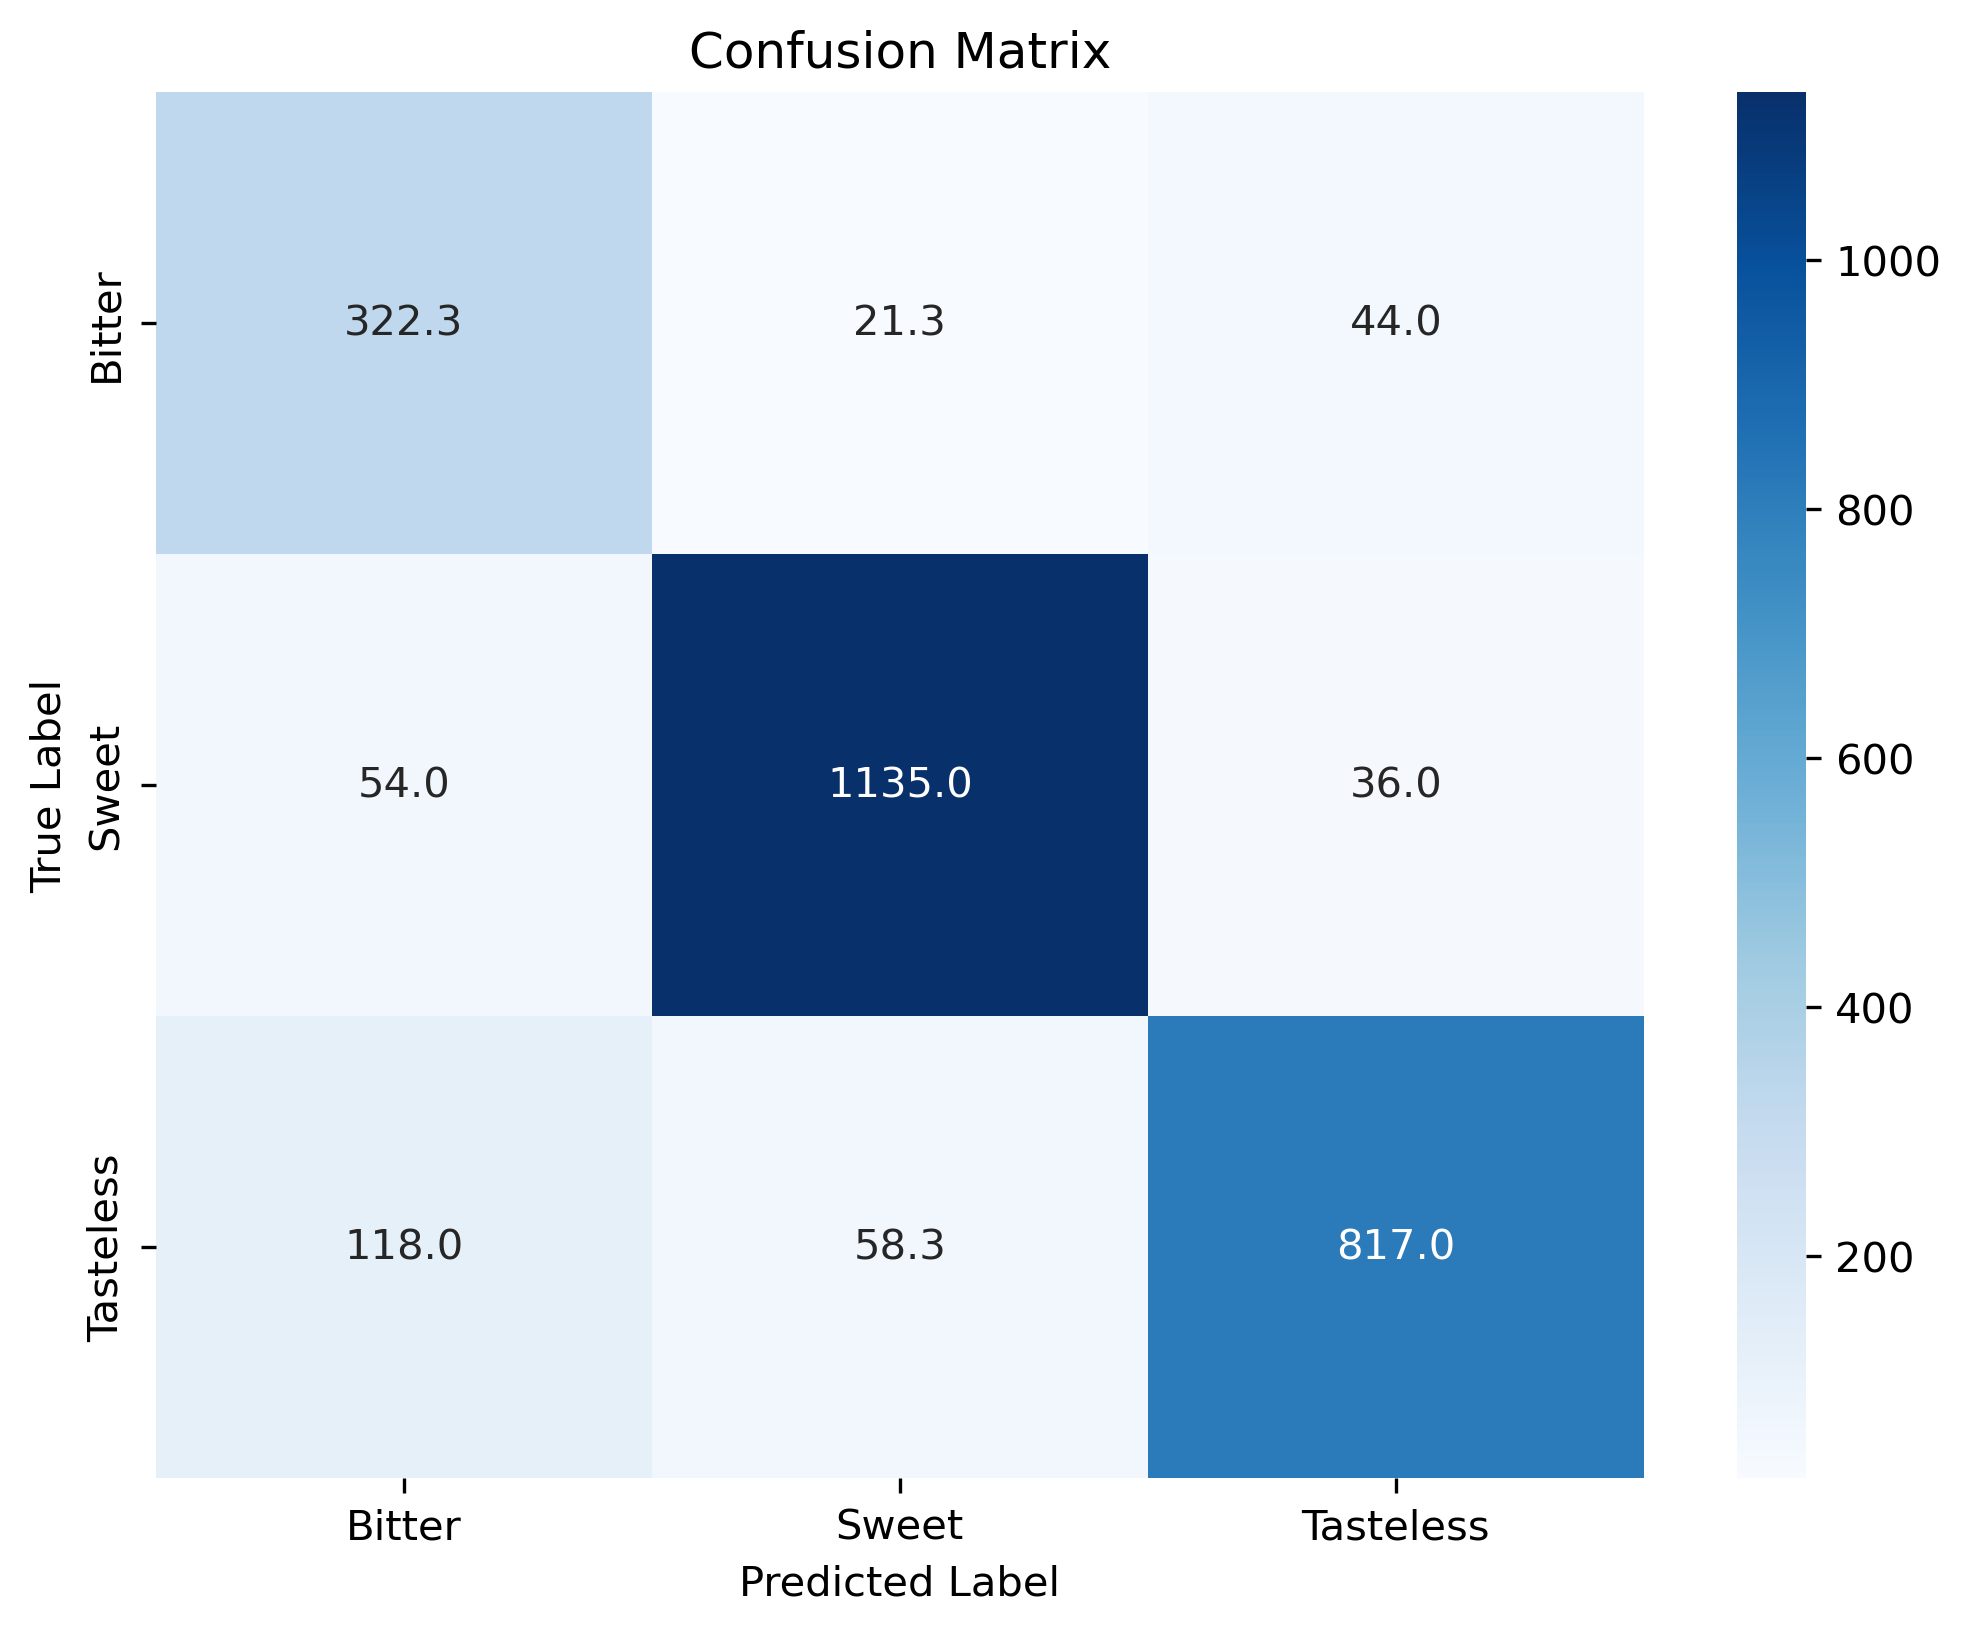

In [5]:
# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()